In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import umap
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import string
from matplotlib.lines import Line2D 
from mpl_toolkits.axes_grid1 import make_axes_locatable  

## Create a Map of Materials Space using PDOS Fingerprints

In [34]:
def load_data(pdos_path: str, prop_path: str):
    df = pd.read_csv(pdos_path)
    id_prop_df = pd.read_csv(prop_path)
    id_prop_df.columns = ['id', 'pretty_formula', 'band_gap', 'e_above_hull']
    df = id_prop_df.merge(df, on='id', how='inner')
    matrix = df.drop(['Unnamed: 0', 'id', 'pretty_formula', 'band_gap', 'e_above_hull'], axis=1).to_numpy()
    df = df[['id', 'pretty_formula', 'band_gap', 'e_above_hull']]
    return df, matrix


### Functions to filter materials

In [35]:
def get_oxide(row: pd.Series):
    if row['pretty_formula'] is None or row['pretty_formula'] is np.nan:
        return False
    elif 'O' in row['pretty_formula']:
        return True
    else:
        return False

def get_li(row: pd.Series):
    if row['pretty_formula'] is None or row['pretty_formula'] is np.nan:
        return False
    elif 'Li' in row['pretty_formula']:
        return True
    else:
        return False

### Calculate UMAP coordinates

In [36]:
def get_umap_coord(matrix: np.ndarray, random_seed: int):
    map = umap.UMAP(random_state=random_seed)
    coord = map.fit_transform(matrix)
    return coord

### Function for plotting the map of materials space

In [40]:
def get_subplots_sns(df: pd.DataFrame, highlight_groups: list[dict], save_plot: bool):
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1, 1]})
    ax = ax.flatten()

    norm = mcolors.Normalize(vmin=0, vmax=3)

    bg_idx = 0
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sns.scatterplot(data=df, x="x", y="y", ax=ax[bg_idx], hue="band_gap", hue_norm=norm, alpha=1, palette='viridis', s=5)

    group = highlight_groups[0]
    df_pm = df[df['id'].isin(group['ids'])]
    sns.scatterplot(data=df_pm, x="x", y="y", ax=ax[bg_idx], color='red', marker=(4, 1, 45), alpha=1, s=150)
    
    sm.set_array([])
    ax[bg_idx].get_legend().remove()
    ax[bg_idx].set(xlabel=None, ylabel=None)
    ax[bg_idx].set(xticklabels=[], yticklabels=[])
    ax[bg_idx].tick_params(bottom=False, left=False)
    
    point = Line2D([0], [0], label='Photovoltaic Materials', marker=(4, 1, 45), markersize=12, 
         markeredgecolor='w', markerfacecolor='red', linestyle='')
    
    ax[bg_idx].legend(['Photovoltaic Materials'], handles=[point], loc='lower right') 
    
    divider = make_axes_locatable(ax[bg_idx])
    cax = divider.append_axes("left", size="5%", pad=0.1)

    cbar = plt.colorbar(sm, cax=cax, label='Band gap, eV', format=mticker.FixedFormatter(['0.0', '0.5', '1.0', '1.5', '2.0', '2.5', '> 3.0']), extend='max')
    cbar.ax.yaxis.set_ticks_position('left')
    cbar.ax.set_ylabel('Band gap, eV')
    cbar.ax.yaxis.set_label_position('left')

    #Oxide
    ox_idx = 2
    sns.scatterplot(data=df[df['oxide'] == 1], x="x", y="y", ax=ax[ox_idx], color='red', alpha=0.3, legend=False, s=5)
    sns.scatterplot(data=df[df['oxide'] == 0], x="x", y="y", ax=ax[ox_idx], color='black', alpha=0.3, legend=False, s=5)

    group = highlight_groups[3]
    df_c = df[df['id'].isin(group['ids'])]
    sns.scatterplot(data=df_c, x="x", y="y", ax=ax[ox_idx], color='blue', marker='v', alpha=1, legend=False, s=150)
    
    ax[ox_idx].legend(['Oxide', 'Non-Oxide', 'Catalysts'], loc='lower right') 
    leg = ax[ox_idx].get_legend()
    leg.legend_handles[0].set_alpha(1)
    leg.legend_handles[1].set_alpha(1)
    leg.legend_handles[0]._sizes = [30]
    leg.legend_handles[1]._sizes = [30]

    ax[ox_idx].set(xlabel=None, ylabel=None)
    ax[ox_idx].set(xticklabels=[], yticklabels=[])
    ax[ox_idx].tick_params(bottom=False, left=False)

    #Li
    li_idx = 1
    sns.scatterplot(data=df[df['li'] == 0], x="x", y="y", ax=ax[li_idx], color='darkblue', alpha=0.3, legend=False, s=5)
    sns.scatterplot(data=df[df['li'] == 1], x="x", y="y", ax=ax[li_idx], color='gold', alpha=0.3, legend=False, s=5)
    
    group = highlight_groups[1]
    df_se = df[df['id'].isin(group['ids'])]
    sns.scatterplot(data=df_se, x="x", y="y", ax=ax[li_idx], color='orangered', marker='p', alpha=1, s=150)
    group = highlight_groups[2]
    df_bc = df[df['id'].isin(group['ids'])]
    sns.scatterplot(data=df_bc, x="x", y="y", ax=ax[li_idx], color='dodgerblue', marker=(4, 0, 0), alpha=1, legend=False, s=150)
    
    ax[li_idx].legend(['No Lithium', 'Contains Lithium', 'Solid Electrolytes', 'Battery Cathodes'], loc='lower right') 
    leg = ax[li_idx].get_legend()
    leg.legend_handles[0].set_alpha(1)
    leg.legend_handles[1].set_alpha(1)
    leg.legend_handles[0]._sizes = [30]
    leg.legend_handles[1]._sizes = [30]
    ax[li_idx].set(xlabel=None, ylabel=None)
    ax[li_idx].set(xticklabels=[], yticklabels=[])
    ax[li_idx].tick_params(bottom=False, left=False)

    for n, a in enumerate(ax):
        a.text(0.02, 0.94, string.ascii_uppercase[n], transform=a.transAxes, 
                size=20, weight='bold', fontfamily='Times New Roman')

    plt.tight_layout()
    
    if save_plot:
        plt.savefig('MP_PDOS_UMAP.png', dpi=300)

### Load data and get UMAP coordinates
(Can take several minutes)

In [29]:
RANDOM_SEED = 3

fingerprints_path = '../data/materials_space_pdos_fingeprints.csv.gz'
materials_property_path = '../data/materials_prop.csv'

df, matrix = load_data(fingerprints_path, materials_property_path)
coord = get_umap_coord(matrix, random_seed=RANDOM_SEED)
df = pd.concat([df, pd.DataFrame(coord, columns=['x', 'y'])], axis=1)

/Users/ineporozhnii/miniconda3/envs/ocp-models/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### Define materials to highlight on the map

In [38]:
highlight_groups = [{'name': 'Photovoltaic Materials', 'ids': ['mp-2534', 'mp-20351', 'mp-558992', 'mp-1078849', 'mp-2490', 'mp-1069538', 'mp-600089', 'mp-5238', 'mp-406', 'mp-149', 'mp-165'], 'color': 'deepskyblue', 'marker': 'star'},
                    {'name': 'Solid Electrolytes', 'ids': ['mp-696128', 'mp-5614', 'mp-720509', 'mp-985583', 'mp-2251', 'mp-985591', 'mp-950995', 'mp-985592', 'mp-14712', 'mp-23497', 'mp-38684', 'mp-38008', 'mp-1222315'], 'color': 'lawngreen', 'marker': 'diamond-tall'},
                    {'name': 'Battery Cathodes', 'ids': ['mp-19017', 'mp-18997', 'mp-18968', 'mp-25411', 'mp-22526', 'mp-9615', 'mp-21778'], 'color': 'lime', 'marker': 'triangle-up'},
                    {'name': 'Catalysts', 'ids': ['mp-2723', 'mp-825', 'mp-19395', 'mp-1272749', 'mp-1078634', 'mp-19339', 'mp-17554', 'mp-20194'], 'color': 'orangered', 'marker': 'star-diamond'}]

### Find Oxides and Li containing materials

In [31]:
df['oxide'] = df.apply(get_oxide, axis=1)
df['li'] = df.apply(get_li, axis=1)
df['oxide'] = (df['oxide']).astype(int)
df['li'] = (df['li']).astype(int)
df['pretty_formula'] = df['pretty_formula'].astype(str)
df['text'] = df[['id', 'pretty_formula']].apply(lambda x: ' '.join(x), axis=1)

### Plot the map of materials space

/var/folders/93/dbk_xc9d3txf98w62lsjg8k80000gn/T/ipykernel_5589/2138454914.py:25: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax[bg_idx].legend(['Photovoltaic Materials'], handles=[point], loc='lower right')
/var/folders/93/dbk_xc9d3txf98w62lsjg8k80000gn/T/ipykernel_5589/2138454914.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar = plt.colorbar(sm, cax=cax, label='Band gap, eV', format=mticker.FixedFormatter(['0.0', '0.5', '1.0', '1.5', '2.0', '2.5', '> 3.0']), extend='max')


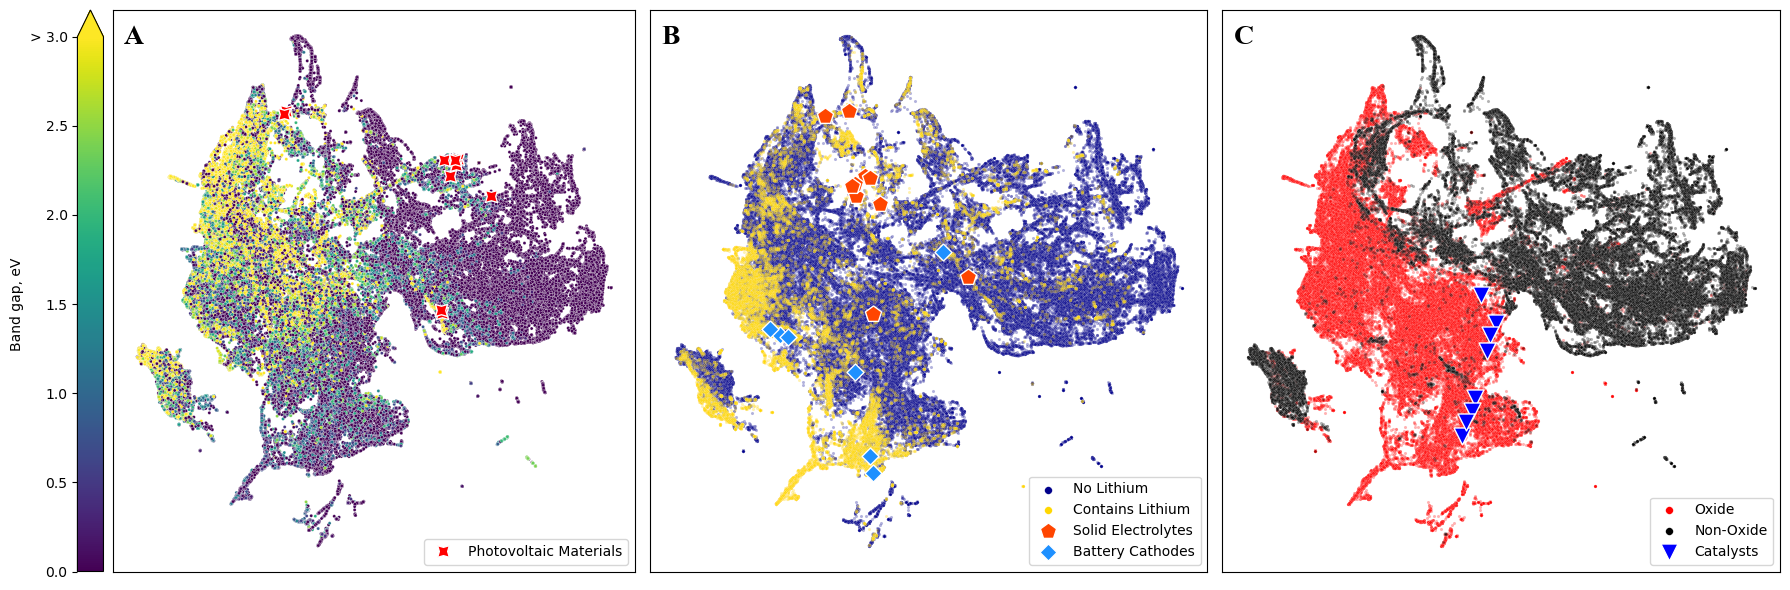

In [41]:
get_subplots_sns(df, highlight_groups, save_plot=False)